graph file found at 


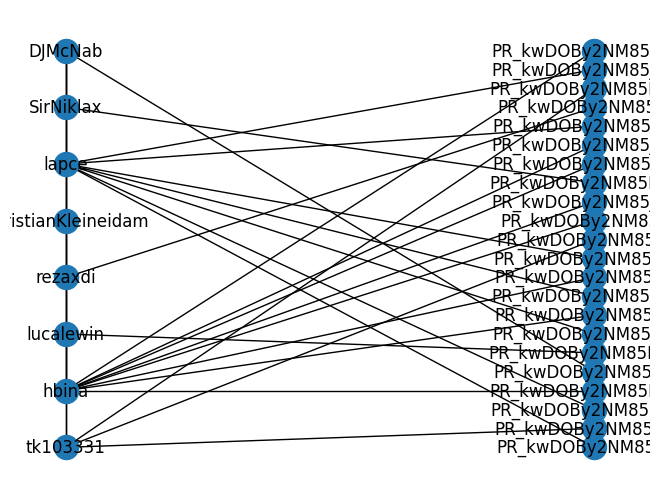

In [6]:

import time
import utils.helper_methods as helper_methods
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import generateGraph
import numpy as np
import random



graphFile = "../graphs/v3/contribConnected.gexf"
edgeCountForDisplay = 30




try:
    gph = nx.read_gexf(graphFile)
    helper_methods.logData("graph file found at " + str())
except Exception as e:
    helper_methods.logData(e)
    gph = nx.Graph()
    helper_methods.logData("new graph file generated")



sampleNodeList = []
sampleEdgeList = []
userList = []
for n in gph.nodes(data = True):
    sampleNodeList.append(str(n[0]))
    
    if(n[1]['bipartite'] == 0):
        userList.append(str(n[0]))
    
    edgeCountForDisplay -= 1
    if(edgeCountForDisplay == 0):
        break


# subgraph_nodes = [1, 2, 'a', 'b', 'c', 'd', 'e', 'f']
subgraph = gph.subgraph(sampleNodeList)        
pos = nx.bipartite_layout(subgraph, userList)
nx.draw(subgraph, pos, with_labels=True)
plt.show()

In [ ]:
B = gph

users = [n for n, d in B.nodes(data=True) if d["bipartite"] == 0]
issues = [n for n, d in B.nodes(data=True) if d["bipartite"] == 1]



In [4]:


def jaccard_coefficient(graph, node1, node2):
    neighbors1 = set(graph.neighbors(node1))
    neighbors2 = set(graph.neighbors(node2))
    intersection = neighbors1.intersection(neighbors2)
    union = neighbors1.union(neighbors2)
    if len(union) == 0:
        return 0
    return len(intersection) / len(union)


def jaccard_link_prediction(graph, threshold):
    predicted_edges = []
    count = 10000
    userCount = 0
    for node1 in users:
        
        userCount += 1
        if(userCount%100 == 0):
            print(userCount)
        for node2 in issues:
            
            if node1 == node2 or graph.has_edge(node1, node2):
                continue
            
            jaccard = jaccard_coefficient(graph, node1, node2)
            if(jaccard >=threshold):
                
                predicted_edges.append((node1, node2, jaccard))
                count -= 1
                if(count == 0):
                    print(node1,end="-------")
                    print(node2, end="-------")
                    print(jaccard)
                    count = 10000
                    
    return sorted(predicted_edges, key=lambda x: x[2], reverse=True)




In [ ]:
def adamic_adar(u, v, G):
    neighbors = list(nx.common_neighbors(G, u, v))
    score = 0
    for w in neighbors:
        degree = G.degree(w)
        if degree != 0:
            score += 1 / np.log(degree)
    return score



similarity_scores = {}
for u in users:
    for v in issues:
        if not gph.has_edge(u, v):
            score = adamic_adar(u, v, B)
            similarity_scores[(u, v)] = score

# Sort the similarity scores in descending order
sorted_scores = sorted(similarity_scores.items(), key=lambda x: x[1], reverse=True)

In [ ]:
issue_nodes = [n for n in test.nodes() if test.nodes[n]['bipartite'] == 0]
user_nodes = [n for n in test.nodes() if test.nodes[n]['bipartite'] == 1]

def preferential_attachment(G, issue, user):
    issue_neighbors = set(G.neighbors(issue))
    user_neighbors = set(G.neighbors(user))
    return len(issue_neighbors) * len(user_neighbors)


def prefAttach(gph, threshold):
    predicted = []
    for issue in issue_nodes:
        for user in user_nodes:
            if gph.has_edge(user, issue):
                continue
            score = preferential_attachment(gph, issue, user)
            if (score>=threshold):
                predicted.append((issue, user, score))
    return sorted(predicted, key=lambda x: x[2], reverse=True)
           

In [ ]:
values = {}
contributions = set() # all nodes with type contribution
starred = set() # all nodes with type starred repo

for n in gph.nodes(data = True):
    if n[1]['bipartite'] == 0:
        values[n[0]] = 1
    else:
        values[n[0]] = 2

for n in gph.edges(data = True):
    if 'contributions' in n[2]:
        contributions.add(n[0])
        contributions.add(n[1])
    else:
        starred.add(n[0])
        starred.add(n[1])

# users -> 1
# issues -> 2
# contribution -> 3
# starred -> 4

threshold = 3
predicted = []

for node in gph.nodes():

    if values[node] == 1: # if it is user
        current_user = node
        weight = {} # to store weights of issues
        prediction = []
        for nodes in gph.neighbors(current_user):
            if values[nodes] == 2: # issues connected to users
                issues = nodes
                for issue_neigh in gph.neighbors(issues): # neighbours of issues connected to users
                    if values[issue_neigh] == 2:
                        if issue_neigh in weight:
                            weight[issue_neigh] += 1
                        else:
                            weight[issue_neigh] = 1
            else: # users connected to users
                user = nodes
                if user in contributions: # if user is connected via contribution
                    for issue_neigh in gph.neighbors(user): # issues that are neighbours of users connected to cuurent user 
                        if values[issue_neigh] == 2:
                            if issue_neigh in weight:
                                weight[issue_neigh] += 2
                            else:
                                weight[issue_neigh] = 2
                else: # if user is connected via starred repo
                    for issue_neigh in gph.neighbors(user): # issues that are neighbours of users connected to cuurent user
                        if values[issue_neigh] == 2:
                            if issue_neigh in weight:
                                weight[issue_neigh] += 1
                            else:
                                weight[issue_neigh] = 1
        
        Issues = list(weight.keys())
        Weights = list(weight.values())

        # print(current_user, end = " --> ")
        # Probability = Element Weight / Sum Of All Weights
        predicted_issue = random.choices(Issues, Weights, k = 1)[0]
        # print(predicted_issue) # k is the number of outputs
        
        predicted.append([current_user, predicted_issue])

for i in predicted:
    print(i)

In [ ]:
# Resource Allocation

C=B
# Initialize sets for each partition
setA = set()
setB = set()
setAll= set()
count = 50

# Iterate through the graph and populate sets for each partition
for n in C.nodes(data = True):
    setAll.add(str(n[0]))
    
    if(n[1]['bipartite'] == 0):
        setA.add(str(n[0]))
    else:
        setB.add(str(n[0]))
    # count -= 1
    # if(count == 0):
    #     break
    


for u in C:
        for v in C[u]:
            if u==v or (u not in usersC):
                  continue
            print(f"Edge: {u} - {v}")



C_edges = []
for u in C:
        for v in C[u]:
            if u==v or (u not in usersC):
                  continue
            #print(f"Edge: {u} - {v}")
            C_edges.append((u,v))

# print(C_edges)
i=0;
for u in C_edges:
        if i<10:
               print(f"Edge: {u}")
               i=i+1




def resource_allocation(G, u, v):
    neighbors_u = set(G[u])
    neighbors_v = set(G[v])
    common_neighbors = neighbors_u.intersection(neighbors_v)
    score = 0
    for neighbor in common_neighbors:
        degree = len(list(G.neighbors(neighbor)))
        score += 1 / degree
    return score

# Compute resource allocation scores for all pairs of nodes in set A and set B
predicted_edges = []
for u in setA:
    for v in setB:
        if not C.has_edge(u, v):
            score = resource_allocation(C, u, v)
            predicted_edges.append((u, v, score))

# Sort the predicted edges by resource allocation score in descending order
predicted_edges.sort(key=lambda x: x[2], reverse=True)

# Print the top 3 predicted edges with the highest resource allocation scores
print("Top 10 Predicted Edges:")
for i in range(10):
    print(f"Edge: {predicted_edges[i][0]} - {predicted_edges[i][1]}, Resource Allocation Score: {predicted_edges[i][2]}")